In [210]:
%load_ext autoreload
%autoreload 2
import sys 
if '/Users/ericliu/Desktop/Latent-Dirichilet-Allocation' not in sys.path: 
    sys.path.append('/Users/ericliu/Desktop/Latent-Dirichilet-Allocation')
import torch as tr 
import numpy as np 
from pprint import pprint 
import pandas as pd 
from collections import defaultdict
from pprint import pprint
import matplotlib.pyplot as plt 
import copy 

from sklearn.decomposition import LatentDirichletAllocation 
from tuotuo.lda_model import LDASmoothed 
from tuotuo.generator import doc_generator 
from tuotuo.document import Document 
from tuotuo.utils import (
    get_vocab_from_docs, 
    get_np_wct, 
    data_loader,
    text_pipeline, 
    process_documents,
)
from tuotuo.text_pre_processor import (
    remove_accented_chars, 
    remove_special_characters, 
    remove_punctuation,
    remove_extra_whitespace_tabs,
    remove_stopwords,
) 
from tuotuo.lda_model import _update 
from tuotuo.cutils import (
    _dirichlet_expectation_1d, 
    _dirichlet_expectation_2d,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Document Generation

In [3]:
gen = doc_generator(
    M = 100,
    L = 20, 
    topic_prior = \
        tr.tensor(
        [1,1,1,1,1], 
        dtype=tr.double
    )
)

In [4]:
gen.alpha

Dirichlet(concentration: torch.Size([5]))

In [5]:
gen.theta.shape

torch.Size([100, 5])

In [6]:
#gen.theta

In [7]:
docs = gen.generate_doc()

In [8]:
print(type(docs)) 

<class 'dict'>


In [9]:
#docs_raw_dict, raw_word_2_idx, raw_idx_2_word = data_loader('ap')

In [10]:
result = process_documents(docs, sample=True)

There are 100 documents in the dataset after processing
On average estimated document length is 10.0 words per document after processing
There are 40 unique vocab in the corpus after processing


In [11]:
print(result.keys())

dict_keys(['documents', 'vocab_doc_count_dict', 'vocab_doc_count_array', 'vocab_to_idx', 'idx_to_vocab'])


In [12]:
print(result.keys())

dict_keys(['documents', 'vocab_doc_count_dict', 'vocab_doc_count_array', 'vocab_to_idx', 'idx_to_vocab'])


In [13]:
print(list(result['vocab_doc_count_dict'].keys()))

['immunology', 'electricity', 'form', 'bankrupt', 'contract', 'content', 'injection', 'allergy', 'court', 'Craftsmanship', 'copyright', 'physical', 'recreation', 'contagious', 'Symmetrical', 'exercise', 'appetite', 'FIFA', 'astrophysics', 'quantum', 'decongestant', 'Olympic', 'research', 'scientst', 'attorney', 'game', 'evidence', 'divorce', 'football', 'accuse', 'infection', 'Technique', 'athletics', 'genetics', 'asymmetrical', 'bruise', 'fever', 'picture', 'energy', 'concert']


In [14]:
list1 = list(result['vocab_doc_count_dict'].keys()) 
list2 = list(result['vocab_to_idx'].keys())

for l1, l2 in zip(list1, list2): 
    assert l1 == l2 

In [15]:
result['vocab_doc_count_array'].T

array([[2., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [16]:
doc_vocab_count = np.zeros(
    (
        len(docs), len(result['vocab_to_idx'])
    ),
    dtype = float,
)

for doc_idx, doc in enumerate(result['documents']): 
    for word in doc: 
        vocab_idx = result['vocab_to_idx'][word]
        doc_vocab_count[doc_idx, vocab_idx] += 1 

print(doc_vocab_count.shape)

(100, 40)


In [17]:
doc_vocab_count 

array([[2., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [18]:
(result['vocab_doc_count_array'].T == doc_vocab_count).all()

True

In [19]:
doc_vocab_count

array([[2., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [20]:
doc_vocab_count_df = pd.DataFrame(
    data = doc_vocab_count,
    columns = list(result['vocab_to_idx'].keys())
)
doc_vocab_count_df

,immunology,electricity,form,bankrupt,contract,content,injection,allergy,court,Craftsmanship,...,infection,Technique,athletics,genetics,asymmetrical,bruise,fever,picture,energy,concert
0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
96,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
97,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
98,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0


In [21]:
train_docs = Document(docs)


There are 100 documents in the dataset after processing
On average estimated document length is 20.0 words per document after processing
There are 40 unique vocab in the corpus after processing


# Our Model

Topic Dirichlet Prior, α
[[1.04708219 0.98292693 0.97347267 0.97347428 1.16278368]]

Exchangeable Word Dirichlet Prior, Eta 
1

Var Inf - Word Dirichlet prior, Lambda
(5, 40)

Var Inf - Topic Dirichlet prior, Gamma
(100, 5)

Init perplexity = 85.05043007230731
End perplexity = 47.02075175995182
Alpha -> [[1.04708219 0.98292693 0.97347267 0.97347428 1.16278368]]
Gamma -> 
Gradient -> [[ 7.82534007  5.38270751 -5.40704078 12.27397335 16.23739257]]
Alpha -> [[1.20495454 1.11243024 1.03809162 1.1414265  1.40963694]]
Gamma -> 
Gradient -> [[ 1.11549043  0.67004398 -0.70965836  1.93964376  2.91114328]]
Alpha -> [[1.24028282 1.14083319 1.05495169 1.1802229  1.47113214]]
Gamma -> 
Gradient -> [[ 0.03465675  0.01695829 -0.02384606  0.06897264  0.12284423]]
Alpha -> [[1.24165599 1.14192443 1.05565932 1.18176861 1.4737839 ]]
Gamma -> 
Gradient -> [[ 4.14197506e-05  1.42829655e-05 -3.41328701e-05  9.80465720e-05
   2.19532080e-04]]
Alpha -> [[1.24165805 1.14192607 1.05566047 1.18177098 1.47378837]

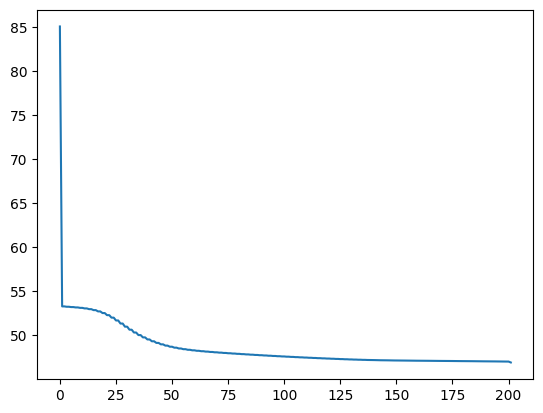

In [274]:
lda = LDASmoothed(
    num_topics = 5, 
    exchangeable_prior = False,
)

expec_logs, perplexes = lda.fit(
    train_doc= train_docs,
    sampling= False,
    verbose=True,
    return_perplexities=True,
)

vars = _update(
    lda._alpha_,
    lda._gamma_,
    lda.M, 
)

perplexes.append(
    lda.approx_perplexity(
        train_docs.doc_vocab_count_array
    )[0]
)

plt.plot(perplexes)
print(perplexes[-1])
#print(lda._alpha_)
#print(lda._eta_)

Topic Dirichlet Prior, α
[[1.04708219 0.98292693 0.97347267 0.97347428 1.16278368]]

Exchangeable Word Dirichlet Prior, Eta 
1

Var Inf - Word Dirichlet prior, Lambda
(5, 40)

Var Inf - Topic Dirichlet prior, Gamma
(100, 5)

Init perplexity = 85.05043007230731


/Users/ericliu/Desktop/Latent-Dirichilet-Allocation/tuotuo/lda_model.py:541: UserWarning: Update Eta: Maximum iteration reached at step 10001
  


End perplexity = 40.05947782825555
40.05947782825555


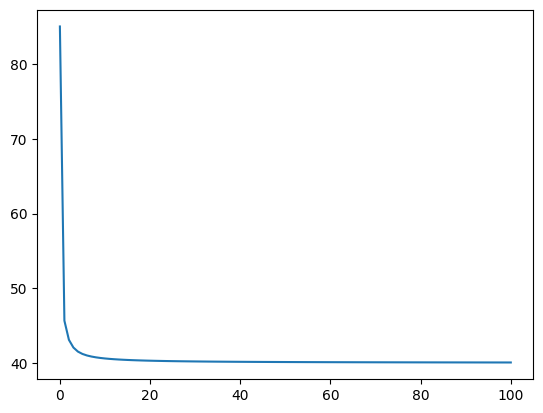

In [298]:
lda = LDASmoothed(
    num_topics = 5, 
    exchangeable_prior = False,
)
expec_logs, perplexities = \
    lda.fit(
    train_doc= train_docs,
    sampling= False,
    verbose=True,
    return_perplexities=True,
)
plt.plot(perplexities)
print(perplexities[-1])

M Step: Iteration 0, Delta Alpha = 8.640199666842818e-12
Alpha Old:[[402.18557603 394.56256017 392.23090426 393.07064214 422.37086408]] -> Alpha New:[[402.18557603 394.56256017 392.23090426 393.07064214 422.37086408]]
40.059477828259254


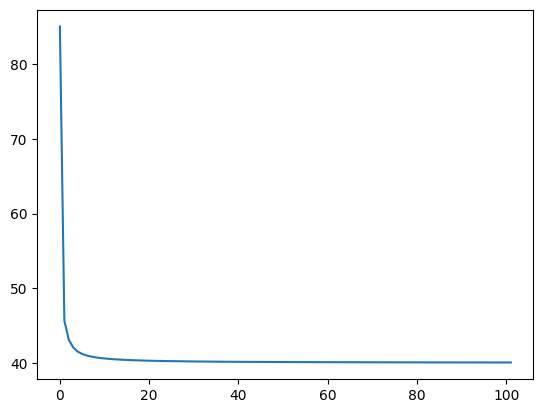

In [299]:
lda.update_alpha(verbose=True)

perplexities.append(
    lda.approx_perplexity(
        train_docs.doc_vocab_count_array
    )[0]
)

plt.plot(perplexities)
print(perplexities[-1])

M Step: delta eta is 6.62339516566135e-10
Eta Old 753.850523450796 -> Eta New 753.8505234501337
40.059477828259254


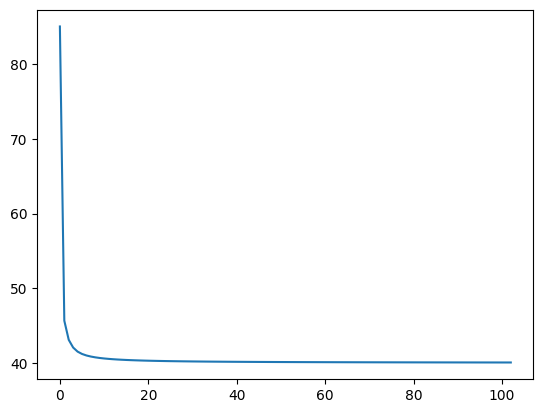

In [301]:
lda.update_eta(verbose=True)


perplexities.append(
    lda.approx_perplexity(
        train_docs.doc_vocab_count_array
    )[0]
)

plt.plot(perplexities)
print(perplexities[-1])

In [302]:
print(lda._alpha_)

[[402.18557603 394.56256017 392.23090426 393.07064214 422.37086408]]


In [303]:
print(lda._eta_)

753.8505234501337


- As we can see, without update the hyper-parameter $\alpha$ and $\eta$, we extract keywords from topics almost correctly. 

Although we still can see that some are not perfect, i.e. electricity ranked higher than scientist 

In [304]:
lda.get_top_k_words(5)

Topic 0
Top 1 -> picture
Top 2 -> copyright
Top 3 -> allergy
Top 4 -> Symmetrical
Top 5 -> fever

Topic 1
Top 1 -> picture
Top 2 -> allergy
Top 3 -> copyright
Top 4 -> Symmetrical
Top 5 -> fever

Topic 2
Top 1 -> picture
Top 2 -> allergy
Top 3 -> copyright
Top 4 -> Symmetrical
Top 5 -> fever

Topic 3
Top 1 -> picture
Top 2 -> allergy
Top 3 -> copyright
Top 4 -> Symmetrical
Top 5 -> fever

Topic 4
Top 1 -> picture
Top 2 -> copyright
Top 3 -> allergy
Top 4 -> Symmetrical
Top 5 -> fever



# Target model

alpha -> 1
eta -> 1
lambda
(5, 40)
Init perplexity = 100.09491669750783
End perplexity = 51.81904206040911


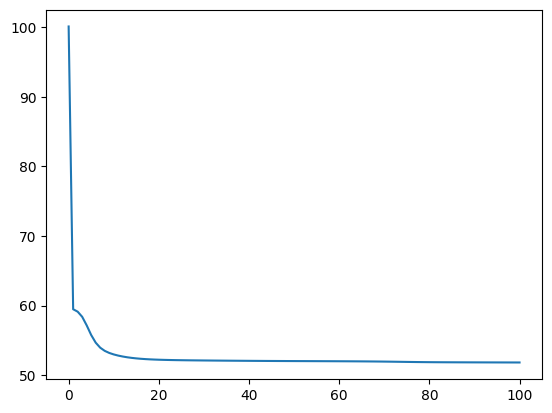

In [84]:
sklearn_lda = LatentDirichletAllocation(
    n_components=5,
    random_state=42,
    doc_topic_prior= 1,
    topic_word_prior= 1,
)
sklearn_lda._init_latent_vars(n_features = lda.V)

print(f"alpha -> {sklearn_lda.doc_topic_prior}")
print(f"eta -> {sklearn_lda.topic_word_prior}")

print('lambda')
print(sklearn_lda.components_.shape)
#assert (sklearn_lda.components_ == lambda_init).all()

perplxities_sklearn = []
init_perplexity = sklearn_lda._perplexity_precomp_distr(
    doc_vocab_count, 
    doc_topic_distr = lda._gamma_,
    sub_sampling=False
)
print(f"Init perplexity = {init_perplexity}")
perplxities_sklearn.append(init_perplexity)

for i in range(100):
    sklearn_lda._em_step(doc_vocab_count, doc_vocab_count.shape[0], True, )
    em_step_perplexity = sklearn_lda.perplexity(doc_vocab_count)
    #print(f"{i+1} EM step perplexity is {em_step_perplexity}")
    perplxities_sklearn.append(em_step_perplexity)
print(f"End perplexity = {perplxities_sklearn[-1]}")
plt.plot(perplxities_sklearn)